# 4-7 OpenPose の推論

## 準備
最初に PyTorch で学習させた学習済み OpenPose モデルをダウンロードしておく．
次に，学習済みネットワークをロードする．
実装は次の通り．

In [2]:
import torch
from utils.openpose_net import OpenPoseNet

# 学習済みモデルと本章のモデルでネットワークの層の名前が違うので対応させてロードする

# モデルの定義
net = OpenPoseNet()

# 学習済みパラメータをロードする
net_weights = torch.load('./weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# ロードした内容を本書で構築したモデルのパラメータ名 net.state_dict().keys() にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]
    
# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print(' ネットワーク設定完了:学習済みの重みをロードしました ')

 ネットワーク設定完了:学習済みの重みをロードしました 


続いて事前に準備しておいた草野球の画像の前処理を行う．

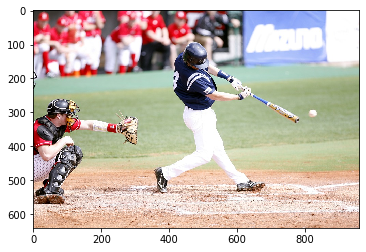

In [5]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

test_image = "./data/hit-1407826_960_720.jpg"
oriImg = cv2.imread(test_image)

# BGR => RGB に変換して表示
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像サイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 画像の前処理
img = img.astype(np.float32) / 255.

# 色情報標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
preprocessed_img = img.copy()[:, :, ::-1]  # BGR => RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]
    
# (高さ、幅、色) => (色、高さ、幅)
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像を Tensor に変換
img = torch.from_numpy(img)

# ミニバッチ化:torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

続いて OpenPose のネットワークに前処理した画像を入力し，heatmaps と PAFs を求める．
出力結果の heatmaps と PAFs のテンソルを NumPy に変換し，それぞれの画像サイズを元の画像サイズと同じに拡大する．

In [6]:
# OpenPose で heatmaps と PAFs を求める
net.eval()
predicted_outputs, _ = net(x)

# 画像をテンソルから NumPy に変化しサイズを戻す
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

左肘と左手首の heatmap と左肘と左手首をつなぐ PAF を可視化してみる．

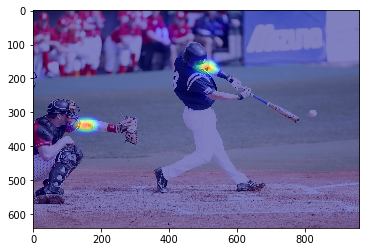

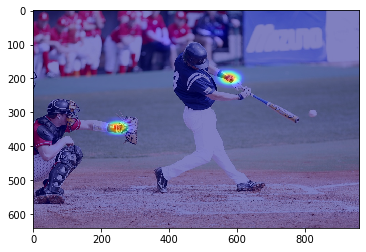

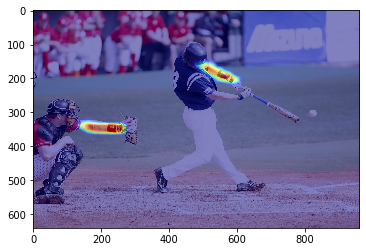

In [9]:
# 左肘と左手首の heatmap、そして左肘と左手首をつなぐ PAF を可視化する
from PIL import Image
from matplotlib import cm

# 左肘
heat_map = heatmaps[:, :, 6] # 6 は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 左手首
heat_map = heatmaps[:, :, 7] # 7 は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 左肘と左手首をつなぐ PAF
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

これを見ると，各人物の左肘と左手首の位置と各人物ごとに左肘と左手首をつなぐ PAF が推定できているように見える．  

最後に heatmaps と PAFs から各人物の各部位をつなぐリンクを求める関数 decode_pose を用意する．
関数 decode_pose に引数として元画像，heatmaps，PAFs を入力すると推定した姿勢を上書きした画像が出力される
ここでは，このリンクを推定する関数 decode_pose が何をしているのかについて概要を解説する．  
まず heatmaps では，ぼやっと身体部位の位置が表現されているので，その中で最大値のピクセルを求め左肘や左手首の位置を同定する．
単純に周囲と比べて最大でかつ一定の閾値よりも大きな値を持つピクセルを身体部位の部位ピクセルと決定する．
次に抽出された各部位の部位間について結合の可能性を計算する．
今回は身体部位が18 か所あるので、組み合わせ的には 18 * 17 / 2 = 153 ペアある．
これは人物が 1 人の場合であり，写真に写っている人数が多いとそれだけ部位数が増えてリンクの可能性も増える．
ただし，PAFs の 37 リンクのみに OpenPose は着目しているので、部位間の結合も37ペアだけを考えることとする
身体部位を heatmaps から特定した後、例えば左肘と左手首のペアを求めるのであれば，上図では左肘と左手首がそれぞれ 2 つ検出されている．
ここでは便宜的に左肘1，左肘2，左手首1，左手首2と呼ぶ．

<img src="../image/p237.png">

各左肘がどの左手首とつながっているのか，その可能性を左肘の座標と各左手首の座標の間の PAF の値を使用して計算する．
例えば左肘1と左手首1のつながり度合いを計算する際には，上図のような左肘1と左手首1を斜めにつなぐ頂点を持つ長方形を考える．
そして左肘1と左手首1を直線上につないだ間にあるピクセルの PAF の和を求める．
また左肘1と左手首1をつなぐ直線からずれた場所の PAF については，そのずれ方(傾き方)を考慮して PAF の値を小さくし，PAF の和に加える．
こうして左肘1と左手首1をつなぐ領域内の PAF の値の総和を計算すると左肘1と左手首1のつながってい程度がわかる．
同様に左肘1と左手首2の PAF の総和を計算し，左手首1の場合と比較して，大きかった方と最終的にリンクをつなぐ．

左肘と左手首だけでなく PAFs で求めた37種類のリンクについて各部位がそれぞれつながる可能性を計算する．
ここでは，左肘と左手首だけからそのつながりを決定しているが，本来であれば左肩1，左肩2などの存在も考慮し，左肩，左肘，左手首など検出された全部位の全パターンの組み合わせで PAF が最大になるように 1 人の人間のリンクを決定する方が正確である．
しかし，全組み合わせを考慮し全身のつながり度合いの総合計をきちんと計算するのは計算コストが高い．
そこで OpenPose では全身の考慮はせず，リンクがつながる各部位間の PAF 情報のみを考慮してリンクを決定する．  
こうして各部位を組み合わせると，場合によってはリンクのつながりをたどっていくと首が2つ存在するといった場合がありえる．
これは合計18部位の人体パーツをつなぐだけであれば，今回の構成の場合，合計 17 リンクを計算するだけで良いが，精度を高めるために冗長性を持たせて37リンクを計算しているためである．
さらに計算コストを下げるために，前述した通り全身のつながりを考慮せず2つの部位間の PAF のみでリンクを決定している．
その結果，1つのつながっているリンクをたどると首が2つ存在するという場合などがありえる．
このようにつながっているリンクをたどったときに同じ部位が複数リンクされた場合は2人以上の人間の部位が混ざっていると判断し，適切にリンクを分割する操作を行う．

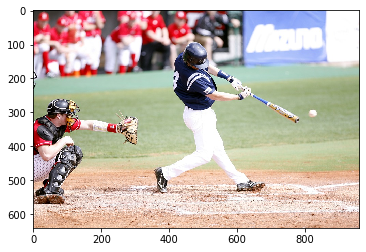

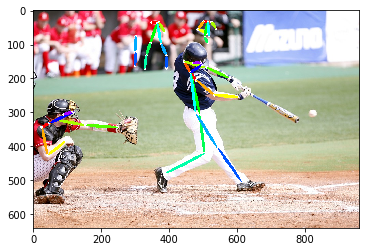

In [10]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

# 結果を描画
plt.imshow(oriImg)
plt.show()
plt.imshow(result_img)
plt.show()

上記の結果を見るとなんとなくうまく推定できているようにも見えるが，キャッチャーの脚がうまく推定できていないなど，細かな点で間違った推定を行っている．
精度を高めるには推論対象の画像に対してデータオーギュメンテーションを施し，これによって得られた画像の全てについて姿勢推定を行った上で，結果を全て統合する．

## まとめ
ここで紹介した手法は OpenPose の初期バージョンについてのみ解説を行ったが，最新版ではいくつか改良が施されている．
最新版では，精度と処理速度を高めるためネットワークの形や使用する畳み込み層のカーネルサイズが変化している．
heatmaps よりも PAFs の方が姿勢推定に重要なので PAFs の正確な推定に重きを置いたネットワークに変化している．
2つ目の変更点は身体部位の追加です。具体的には足先という新たなアノテーションを用意して学習している．
3つ目は PAFs を37個からさらに冗長な PAFs を追加している．
この2，3点目の変更により人が重なって写っている状態でもより正確に各人の姿勢を推定できるようにしている．